# Interictal Spike Detection

In [3]:
!rm -rf __pycache__

import os, glob, re, pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from ieeg.auth import Session
from matplotlib import pyplot as plt
from scipy.ndimage import label
from scipy.signal import butter, filtfilt, iirnotch


from get_iEEG_data import *
from IES_helper_functions import *

## Erin's Spike Detector

I will try to reproduce the spike detectors proposed here: https://www.sciencedirect.com/science/article/pii/S1388245707001666?via%3Dihub, which are the ones that Erin currently uses

Actually, Erin's code can be accessed here: https://github.com/erinconrad/FC_toolbox/blob/main/spike_detector/clean_detector.m
so it is just a matter of translating this matlab code into a Python code

Detector based off of Erin's code - there are 3 functions that are needed for this to run: 1. function for filtering the ieeg data (`eegfilt`), 2. function for finding peaks (`findpeaks`), 3. function for ensuring that spikes are detected in more than one channel (`multi_channel_requirements`)

`findpeaks` function definition

In [4]:
def findpeaks(s):
    """
    Inputs:
        s: timeseries signal
    Outputs:
        p: location in the signal with an increasing signal (positive slope)
        t: location in the signal with a decreasing signal (negative slope)
    """
    ds = np.diff(s)
    ds = np.hstack((ds[0], ds))  # pad diff
    filt = np.where(ds[1:] == 0)[0] + 1  # find zeros
    ds[filt] = ds[filt - 1]  # replace zeros
    ds = np.sign(ds)
    # compute the second derivative -  inflection points
    ds = np.diff(ds)
    t = np.where(ds > 0)[0]
    p = np.where(ds < 0)[0]
    return p, t

`eegfilt` function definition

In [5]:
def eegfilt(x, fc, typ, fs):
    """
    Inputs:
        x: timeseries signal
        fc: cutoff frequency
        typ: type of filtering (lp - lowpass, hp - highpass)
        fs: sampling rate of x
    Outputs:
        p: location in the signal with an increasing signal (positive slope)
        t: location in the signal with a decreasing signal (negative slope)
    """
    # filter eeg data using Butterworth filter
    # out = eegfilt(data,cutfreq,typ);
    # out = eegfilt(data,70,'hp'); high pass with 70Hz cutoff

    # EEG_BUTTER - Butterworth filter implementation
    # xf = eeg_butter(x,sampl_freq,cutoff_freq,filter_type,num_poles)

    np = 6  # order of the butterworth filter

    if np.sum(fc >= fs / 2):
        raise ValueError("Cutoff frequency must be < one half the sampling rate")

    fn = fs / 2

    if typ == "bp":
        typ = "lp"

    if typ == "lp":
        B, A = butter(np, fc / fn)
    elif typ == "hp":
        B, A = butter(np, fc / fn, "high")
    elif typ == "st":
        B, A = butter(np, fc / fn, "stop")

    out = filtfilt(B, A, x)
    return out

`multichannel_requirements` function that makes sure that the spikes occur in 2 or more channels

In [6]:
def multichannel_requirements(gdf, nchs, fs):
    # Parameters
    min_chs = 2  # spike should be on at least 2 channels
    max_chs = int(nchs * 0.5)  # on no more than half the channels
    min_time = int(100 * 1e-3 * fs)  # 100 ms to look for other spikes

    final_spikes = []

    s = 0
    curr_seq = [s]
    last_time = gdf[s, 1]

    while s < gdf.shape[0] - 1:
        # move to next spike time
        new_time = gdf[s + 1, 1]

        # if it's within the time diff
        if new_time - last_time < min_time:
            curr_seq.append(s + 1)  # append it to the current sequence

            if s == gdf.shape[0] - 2:
                # done with sequence, check if the number of involved chs is appropriate
                l = len(np.unique(gdf[curr_seq, 0]))
                if min_chs <= l <= max_chs:
                    final_spikes.append(
                        np.hstack(
                            (
                                gdf[curr_seq, :],
                                (gdf[curr_seq, 1] - np.min(gdf[curr_seq, 1]))[
                                    :, np.newaxis
                                ],
                            )
                        )
                    )

        else:
            # done with sequence, check if the length of sequence is appropriate
            l = len(np.unique(gdf[curr_seq, 0]))
            if min_chs <= l <= max_chs:
                final_spikes.append(
                    np.hstack(
                        (
                            gdf[curr_seq, :],
                            (gdf[curr_seq, 1] - np.min(gdf[curr_seq, 1]))[
                                :, np.newaxis
                            ],
                        )
                    )
                )

            # reset sequence
            curr_seq = [s + 1]

        # increase the last time
        last_time = gdf[s + 1, 1]

        # increase the current spike
        s += 1
    if len(final_spikes) > 0:
        multichannel_spikes = np.vstack(final_spikes)
    else:
        print("No spikes meet the criteria...")
        multichannel_spikes = []
    return multichannel_spikes

#### Actual Spike Detector

In [7]:
def clean_detector(
    eeg_df,
    fs,
    remove_channels=[
        "EEG EKG 02-Ref",
        "ECG1",
        "EEG EKG1-Ref",
        "EKG2",
        "EKG",
        "EKG1",
        "EKG02",
        "EEG EKG2-Ref",
        "EEG EKG 01-Ref",
        "EEG EKG-Ref",
        "ECG2",
        "EKG01",
    ],
):
    # extract the data from the dataframe
    eeg = eeg_df.values

    ## Parameters
    tmul = 19  # minimum relative amplitude (compared to baseline)
    absthresh = 100  # minimum absolute amplitude (uV)
    sur_time = (
        0.5  # surround time (in s) against which to compare for relative amplitude
    )
    close_to_edge = 0.05  # time (in s) surrounding start and end of sample to ignore
    too_high_abs = 1e3  # amplitude above which I reject it as artifact
    spkdur = [15, 200]  # spike duration must be within this range (in ms)
    spkdur = np.array(spkdur) * fs // 1000  # convert above to samples
    lpf1 = 30  # low pass filter for artifact component
    hpf = 7  # high pass filter for spikey component

    ## Initialize things
    all_spikes = np.empty((0, 4))
    nchs = eeg.shape[1]
    ch_names = list(eeg_df.columns)

    ## Iterate channels and detect spikes
    print("Detecting spikes through channels")
    for j in range(nchs):
        if ch_names[j] not in remove_channels:
            # initialize out array with final spike info
            out = np.empty((0, 3))

            # extract channel data
            data = eeg[:, j]

            # Skip if all nans
            if np.sum(np.isnan(data)) > 0:
                continue

            # re-adjust the mean of the data to be zero
            data = data - np.nanmean(data)

            # initialize array with tentative spike info
            spikes = []

            # Low pass filter to remove artifact
            b, a = butter(4, lpf1 / (fs / 2), btype="lowpass")
            lpdata = filtfilt(b, a, data)  # low pass filter

            # high pass filter to get the spikey part
            b, a = butter(4, hpf / (fs / 2), btype="highpass")
            hpdata = filtfilt(b, a, lpdata)  # high pass filter

            # establish the baseline for the relative amplitude threshold
            lthresh = np.median(np.abs(hpdata))
            thresh = lthresh * tmul  # this is the final threshold we want to impose

            # Run the spike detector to find both negative and positive spikes
            for k in range(2):
                if k == 1:
                    kdata = -hpdata  # flip the sign of the data to find positive spikes
                else:
                    kdata = hpdata

                # find peaks (spp) and troughs (spv) in the data
                spp, spv = findpeaks(kdata)

                # find peak-to-peak durations within allowable range
                idx = np.where(np.diff(spp) <= spkdur[1])[0]

                # peak before list
                startdx = spp[idx]

                # peak after list
                startdx1 = spp[idx + 1]

                # Loop over peaks
                for i in range(len(startdx)):
                    # find the valley that is between the two peaks
                    spkvalley = spv[np.where((spv > startdx[i]) & (spv < startdx1[i]))]

                    # If the height from valley to either peak is big enough, it could be a spike
                    max_height = max(
                        abs(kdata[startdx1[i]] - kdata[spkvalley]),
                        abs(kdata[startdx[i]] - kdata[spkvalley]),
                    )
                    if (
                        max_height > thresh
                    ):  # if amplitude from peak to valley is large enough, append as a spike
                        # add the location of the spike valley, the duration of spike from peak 1 to peak 2 and the amplitude from peak to valley
                        spikes.append(
                            [spkvalley[0], startdx1[i] - startdx[i], max_height]
                        )

            if len(spikes) > 0:
                # Add channel number and convert spike time to samples
                spikes = [[a, b, c[0]] for a, b, c in spikes]
                spikes = np.array(spikes)
                # print
                # spikes[:, -1] = list(map(lambda x: x[0], spikes[:, -1]))
                spikes = spikes.astype(float)

                # check different properties for each of the detected spikes to make sure that they are truly spikes
                # make sure they are not too small in amplitude (noise), too sharp/short in time (noise), or too large (artifact)
                toosmall = []
                toosharp = []
                toobig = []

                # for each spike - spikes is a n_spikes by properties array
                for i in range(spikes.shape[0]):
                    # re-define baseline to be period surrounding spike
                    istart = int(
                        max(1, round(spikes[i, 0] - sur_time * fs))
                    )  # starting time for the surrounding timepoints is either 1 (if spike is at timepoint 0), or at the surrounding timepoint
                    iend = int(
                        min(len(hpdata), round(spikes[i, 0] + sur_time * fs))
                    )  # same but for ending time. It accounts for the spike being in the last timepoint

                    # define a regional local threshold within the specified time range
                    alt_thresh = np.median(np.abs(hpdata[istart:iend])) * tmul

                    if (
                        spikes[i, 2] > alt_thresh and spikes[i, 2] > absthresh
                    ):  # both parts together are bigger than thresh: so have some flexibility in relative sizes
                        if (
                            spikes[i, 1] * 1000 / fs > spkdur[0]
                        ):  # spike wave cannot be too sharp: then it is either too small or noise
                            if spikes[i, 2] < too_high_abs:
                                out = np.vstack(
                                    (out, spikes[i, :])
                                )  # add info of spike to output list
                            else:
                                toobig.append(spikes[i, 0])
                        else:
                            toosharp.append(spikes[i, 0])
                    else:
                        toosmall.append(spikes[i, 0])

                if out.shape[0] > 0:
                    # Re-align spikes to peak of the spikey component
                    timeToPeak = [
                        -0.15,
                        0.15,
                    ]  # Only look 150 ms before and after the currently defined peak
                    fullSurround = [-sur_time, sur_time] * fs
                    idxToPeak = (np.array(timeToPeak) * fs).astype(int)

                    for i in range(out.shape[0]):
                        currIdx = out[i, 0]
                        surround_idx = np.arange(
                            max(1, round(currIdx + fullSurround[0])),
                            min(round(currIdx + fullSurround[1]), len(hpdata)),
                        ).astype(int)
                        idxToLook = np.arange(
                            max(1, round(currIdx + idxToPeak[0])),
                            min(round(currIdx + idxToPeak[1]), len(hpdata)),
                        ).astype(int)
                        snapshot = data[idxToLook] - np.median(data[surround_idx])
                        # Look at the high frequency data (where the mean is subtracted already)
                        I = np.argmax(np.abs(snapshot))
                        # The peak is the maximum absolute value of this
                        out[i, 0] = idxToLook[0] + I - 1

                    all_spikes = np.vstack(
                        (all_spikes, np.hstack((np.full((out.shape[0], 1), j), out)))
                    )

    # convert the last column to a list of numbers instead of a list of arrays
    # output the numpy array with the spikes
    gdf = all_spikes
    gdf = np.unique(gdf, axis=0)

    # sort by times and put ch first
    if gdf.size > 0:
        gdf = gdf[gdf[:, 1].argsort(), :]  # sort by time

        """
        times = gdf[:,0]
        chs = gdf[:,1]
        I = np.argsort(times)
        chs = chs[I]
        times = times[I]
        gdf = np.vstack((chs, times)).T
        """
    # Remove those at beginning and end
    if gdf.size > 0:
        close_idx = int(close_to_edge * fs)
        gdf = gdf[gdf[:, 1] >= close_idx]
        gdf = gdf[gdf[:, 1] <= eeg.shape[0] - close_idx]

    # remove duplicates
    if gdf.size > 0:
        keep = np.ones(gdf.shape[0], dtype=bool)

        # take diff of times
        diff_times = np.hstack((np.inf, np.diff(gdf[:, 1])))

        # take diff of chs
        diff_chs = np.hstack((np.inf, np.diff(gdf[:, 0])))

        # find those that are close in time and the same ch
        too_close = np.logical_and(abs(diff_times) < 100e-3 * fs, diff_chs == 0)

        keep[too_close] = 0
        keep = np.array(keep)

        n_removed = np.sum(~keep)
        gdf = gdf[keep]

    # execute the multichannel requirements
    gdf = multichannel_requirements(gdf, nchs, fs)

    if len(gdf) > 0:
        # convert gdf into a pandas dataframe
        df_spikes = pd.DataFrame()
        df_spikes["Channel Number"] = gdf[:, 0].astype(int)
        df_spikes["Channel Name"] = list(
            map(lambda x: ch_names[x], gdf[:, 0].astype(int))
        )
        df_spikes["Spike Location"] = gdf[:, 1].astype(int)
        df_spikes["Spike Duration"] = gdf[:, 2].astype(int)
        df_spikes["Spike Amplitude"] = gdf[:, 3]
    else:
        df_spikes = pd.DataFrame(
            columns=[
                "Channel Number",
                "Channel Name",
                "Spike Location",
                "Spike Duration",
                "Spike Amplitude",
            ]
        )
    return df_spikes

Function for plotting the spikes

In [8]:
def plot_spikes(ieeg_data, spike_df):
    channels_with_spikes = list(set(spike_df["Channel Number"].values))

    plt.figure(figsize=(20, 20))
    for i, ch in enumerate(channels_with_spikes):
        plt.subplot(len(channels_with_spikes), 1, i + 1)
        plt.plot(ieeg_data.values[:, ch])
        sns.despine(top=True, right=True, left=True, bottom=True)
        plt.xticks([])
        plt.yticks([])

        spike_locations = spike_df[spike_df["Channel Number"] == ch][
            "Spike Location"
        ].values
        spike_amplitudes = spike_df[spike_df["Channel Number"] == ch][
            "Spike Amplitude"
        ].values
        for j, (location, amplitude) in enumerate(
            zip(spike_locations, spike_amplitudes)
        ):
            plt.plot(
                location, ieeg_data.values[location, ch], ".", markersize=10, color="r"
            )
        channel_name = spike_df[spike_df["Channel Number"] == ch][
            "Channel Name"
        ].values[0]
        plt.ylabel(channel_name)

#### Test the Spike Detector

In [9]:
def create_pwd_file(username, password, fname=None):
    if fname is None:
        fname = "{}_ieeglogin.bin".format(username[:3])
    with open(fname, "wb") as f:
        f.write(password.encode())
    print("-- -- IEEG password file saved -- --")


create_pwd_file("dma", "mycqEv-pevfo4-roqfan")

with open("dma_ieeglogin.bin", "r") as f:
    session = Session("dma", f.read())

-- -- IEEG password file saved -- --


In [10]:
with open("dma_ieeglogin.bin", "r") as f:
    s = Session("dma", f.read())
ds = s.open_dataset("HUP210_phaseII")
all_channel_labels = np.array(ds.get_channel_labels())
label_idxs = electrode_selection(all_channel_labels)
labels = all_channel_labels[label_idxs]

In [11]:
ieeg_data, fs = get_iEEG_data(
    "dma", "dma_ieeglogin.bin", "HUP210_phaseII", 596200 * 1e6, 596201 * 1e6, labels
)

In [12]:
ieeg_data

,LA01,LA02,LA03,LA04,LA05,LA06,LA07,LA08,LA09,LA10,...,LP04,LP05,LP06,LP07,LP08,LP09,LP10,LP11,LP12,O2
0,-43.331706,-3.455903,-66.193833,-92.246024,-153.654761,-214.265981,-251.749236,-322.994004,-263.180300,-139.831149,...,-81.080799,-76.827380,-71.244768,-84.802541,-82.675831,-64.067123,60.611221,-103.411249,-141.957859,-11.962741
1,-14.621128,23.659643,-37.217416,-64.067123,-120.424925,-179.706952,-211.873433,-279.928137,-216.924368,-78.422412,...,-60.345382,-56.623640,-51.306866,-64.864639,-61.940414,-44.395061,57.686995,-103.411249,-185.023726,19.672063
2,11.431064,51.306866,-10.899386,-34.824868,-90.916831,-145.945439,-177.048565,-242.976559,-182.897016,-62.737930,...,-39.875803,-35.090707,-32.432320,-45.724254,-49.180157,-33.761513,53.699415,-164.819986,-410.720771,47.585125
3,-3.721742,34.027352,-28.444739,-50.509350,-106.069636,-159.237373,-187.150435,-248.293333,-183.960371,-64.864639,...,-31.900642,-27.381385,-23.659643,-36.685739,-36.685739,-17.811192,43.331706,-107.664668,-444.748122,43.597545
4,-31.103126,7.177645,-53.965253,-74.168994,-124.678344,-175.187694,-195.125596,-253.610107,-187.947951,-49.711834,...,-45.192577,-38.280771,-30.571449,-39.609964,-35.090707,-11.696902,26.849707,-26.318030,-299.068522,-3.987580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,-330.969165,-310.499586,-392.377901,-449.799057,-555.602855,-582.984239,-248.825010,-102.613733,-264.509493,72.839800,...,-217.190207,-226.494561,-215.861013,-241.115689,-263.180300,-280.193975,-16.481999,-169.605082,-251.217559,-43.597545
1020,-330.171649,-309.436231,-391.048708,-447.140671,-551.349436,-578.996659,-245.103269,-100.752862,-262.382784,76.029864,...,-215.329336,-221.177787,-212.936788,-234.469721,-255.736816,-270.092105,6.380128,-166.680856,-249.356688,-30.039772
1021,-328.310778,-308.372876,-389.719514,-446.077316,-549.222726,-575.274917,-243.774075,-104.740442,-266.370364,69.118058,...,-211.607594,-213.468465,-204.695789,-226.228722,-248.027494,-259.990235,26.583869,-162.161599,-246.698301,-32.166481
1022,-319.538101,-301.461070,-383.073547,-438.899671,-541.513404,-566.768079,-240.052334,-108.993861,-269.028751,66.193833,...,-204.961627,-210.012562,-196.986467,-216.658529,-238.988979,-250.951720,42.800029,-159.503212,-245.369108,-41.204996


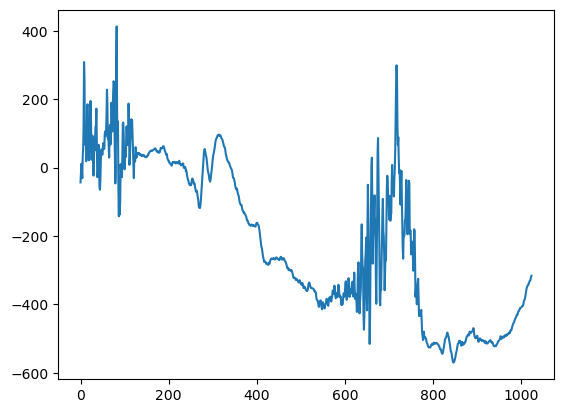

In [13]:
plt.plot(ieeg_data["LA01"])
plt.show()

In [14]:
ieeg_data = common_average_montage(ieeg_data)

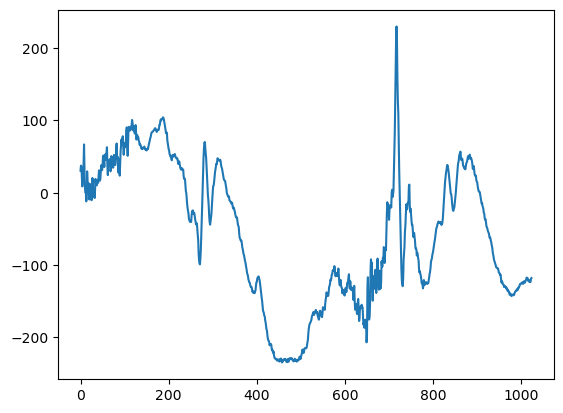

In [15]:
plt.plot(ieeg_data["LA01"])
plt.show()

In [16]:
def notch_filter(data, low_cut, high_cut, fs, order=4):
    nyq = 0.5 * fs
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = iirnotch(w0=(low + high) / 2, Q=30, fs=fs)
    y = filtfilt(b, a, data)
    return y


def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = filtfilt(b, a, data)
    return y


# Apply the filters
for column in ieeg_data.columns:
    ieeg_data[column] = notch_filter(ieeg_data[column], 59, 61, fs)
    ieeg_data[column] = bandpass_filter(ieeg_data[column], 1, 70, fs)

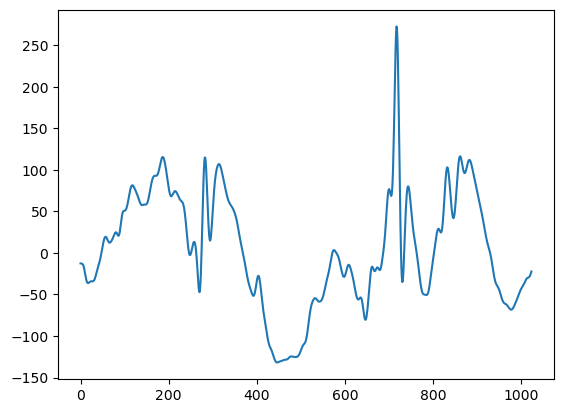

In [17]:
plt.plot(ieeg_data["LA01"])
plt.show()

In [18]:
# Save ieeg_data to a csv file
ieeg_data.to_csv("ieeg_data.csv")

In [19]:
gdf = clean_detector(ieeg_data, int(fs))

Detecting spikes through channels


/mnt/leif/littlab/users/devinma/Libraries/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/leif/littlab/users/devinma/Libraries/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
gdf

,Channel Number,Channel Name,Spike Location,Spike Duration,Spike Amplitude
0,153,LM12,89,55,189.778656
1,163,LN10,146,57,373.212595
2,12,LB01,146,88,750.429920
3,187,LP10,187,59,230.913632
4,126,LK09,256,53,318.931626
5,163,LN10,299,60,373.212595
6,12,LB01,302,61,750.429920
7,126,LK09,406,87,318.931626
8,48,LE02,486,50,857.413866
9,94,LH12,490,46,341.904993


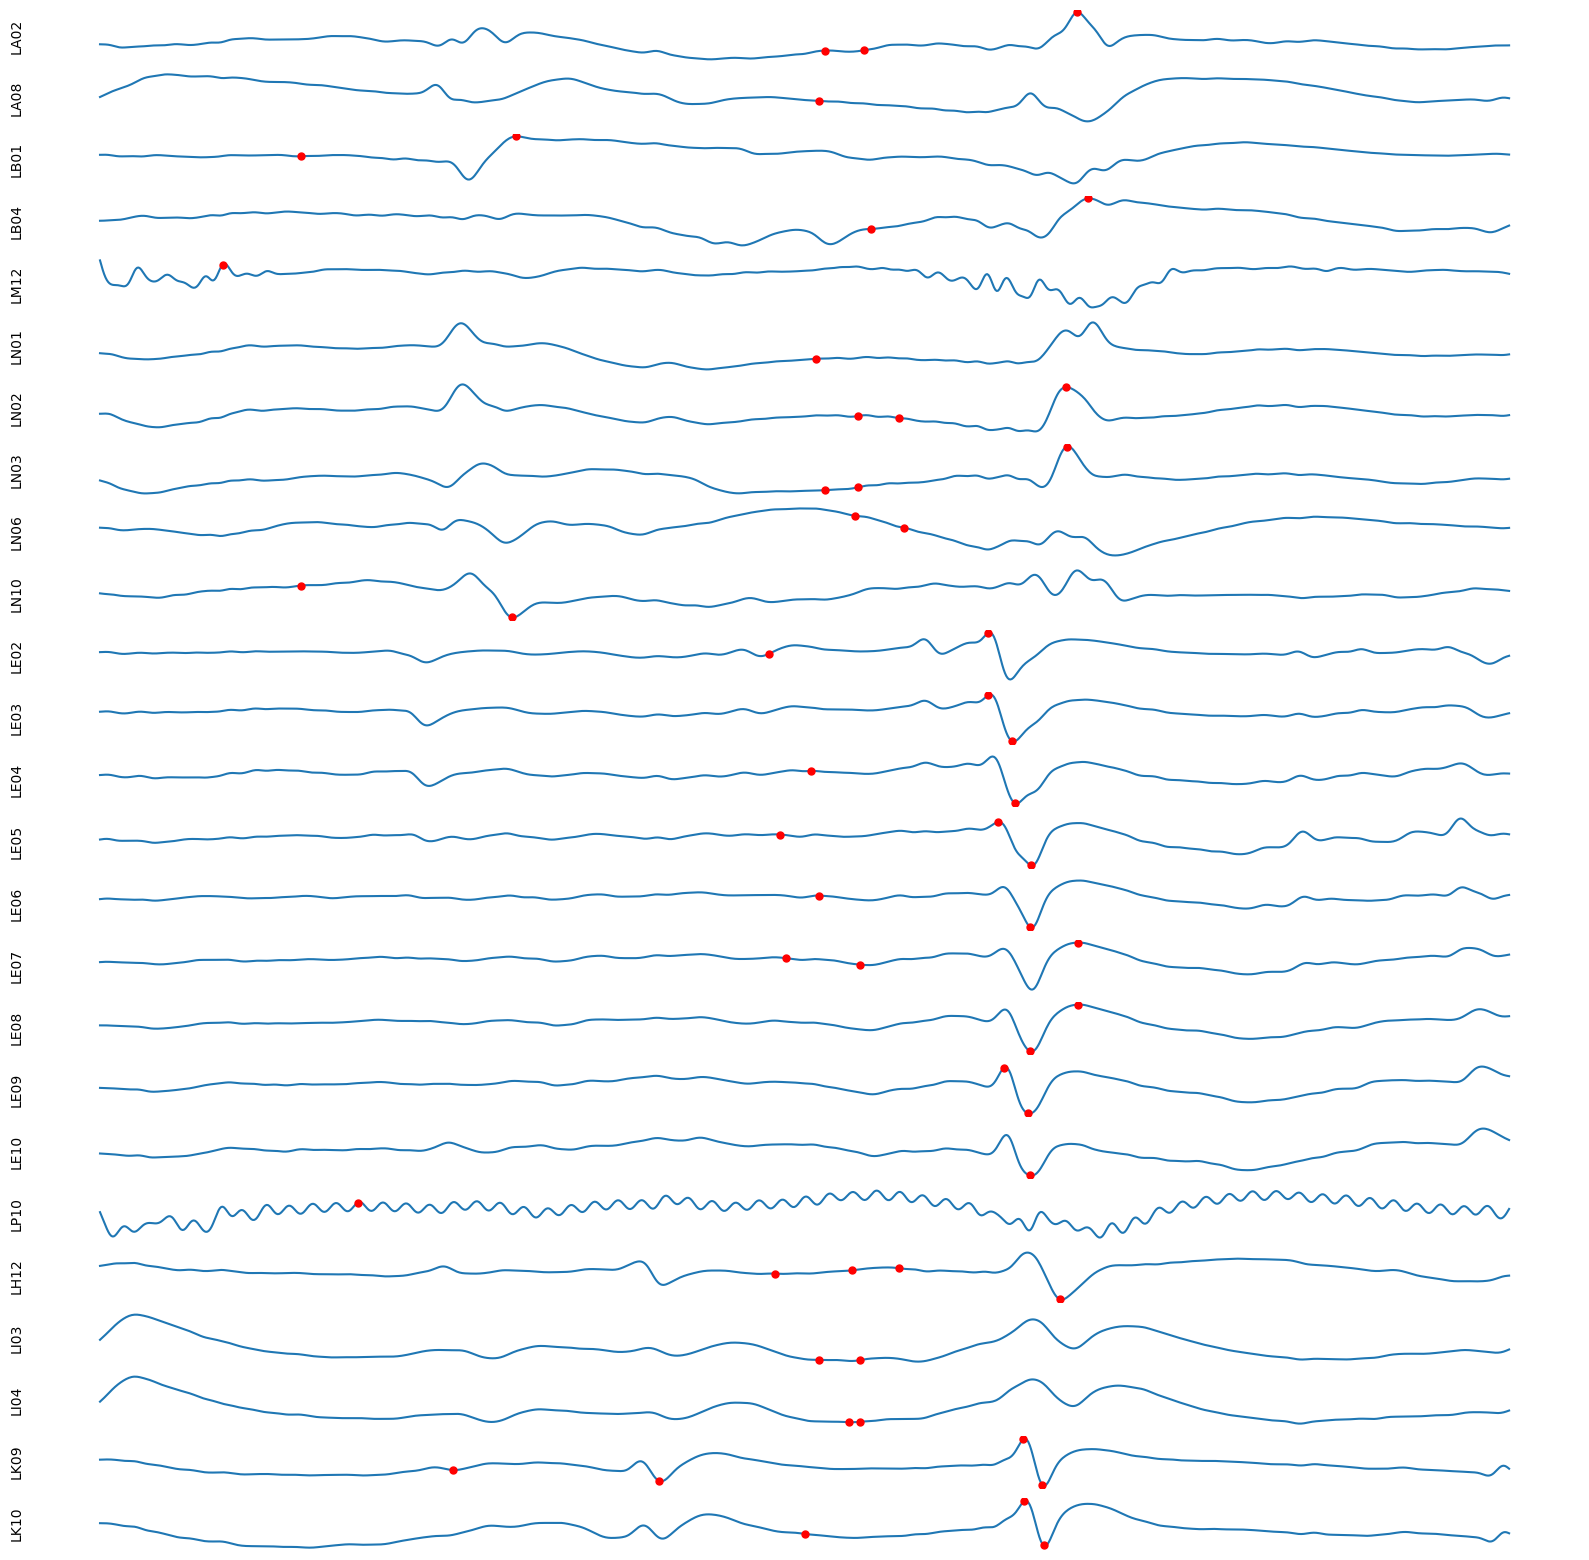

In [21]:
plot_spikes(ieeg_data, gdf)

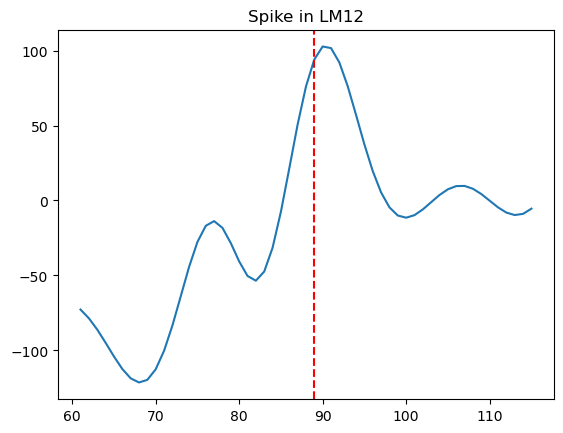

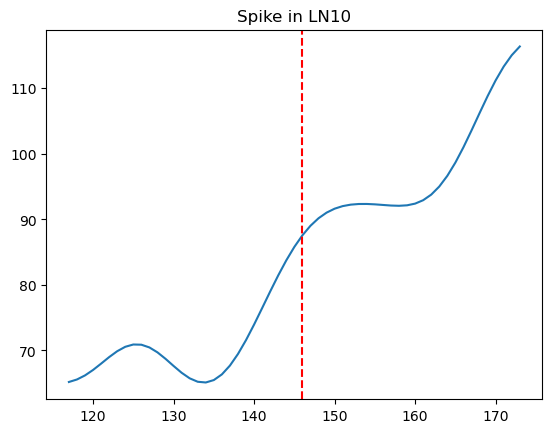

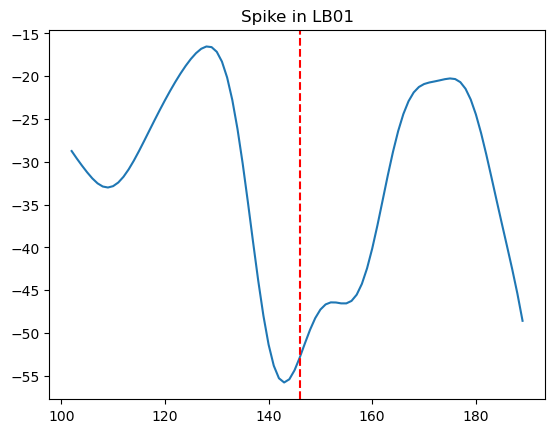

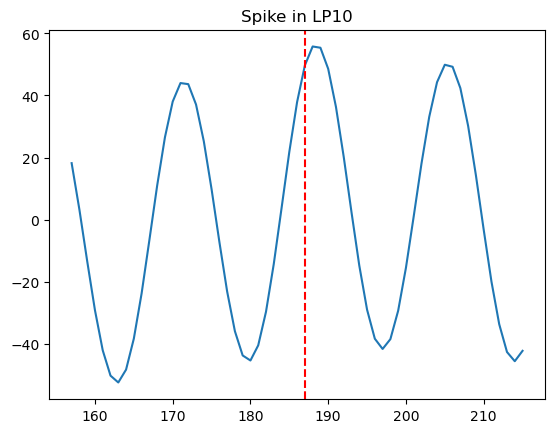

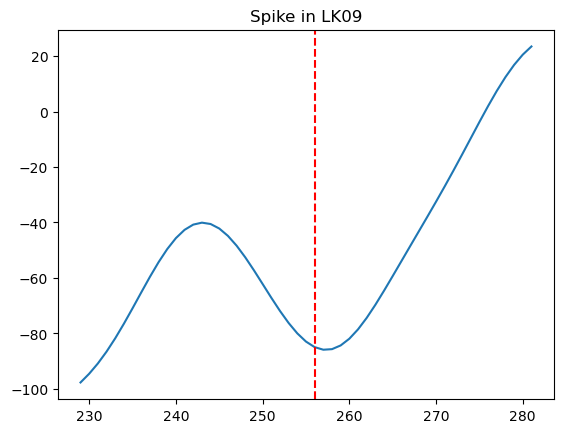

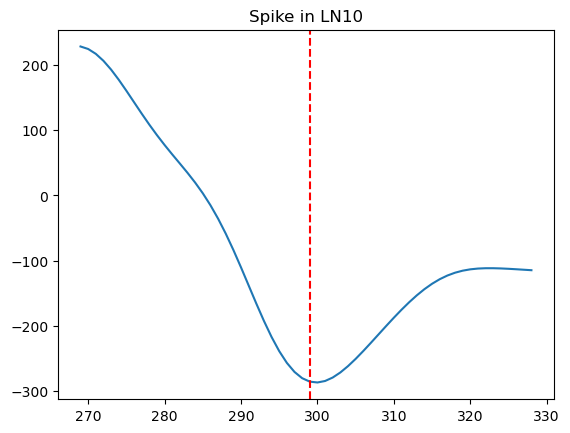

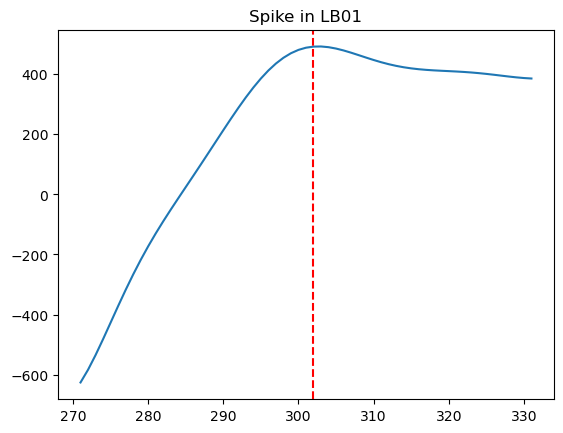

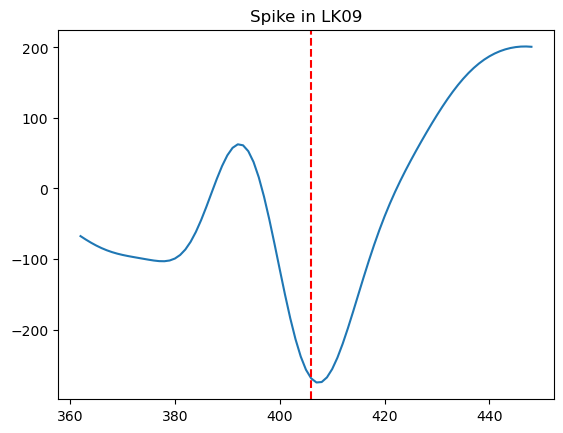

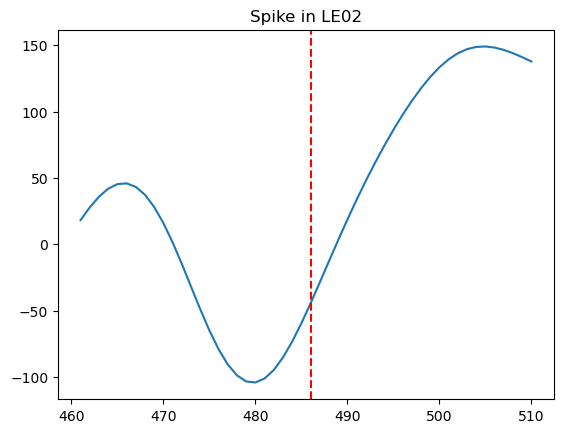

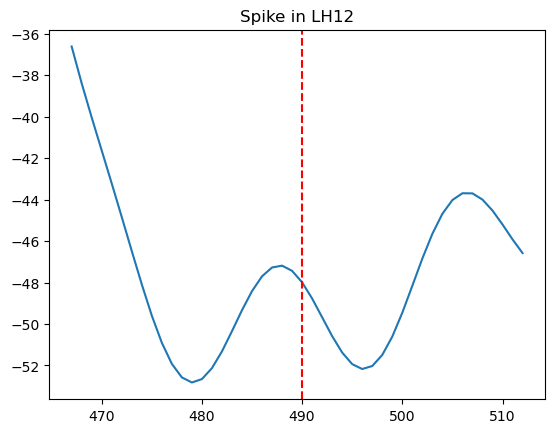

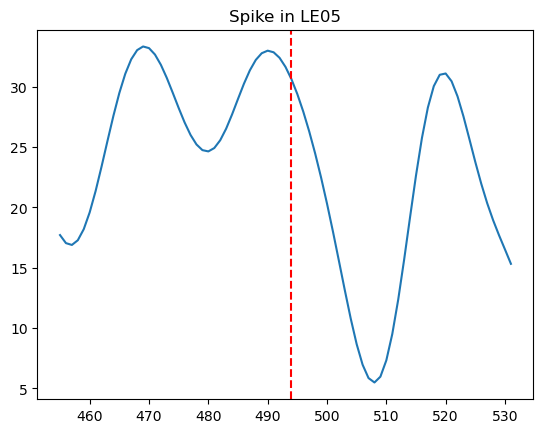

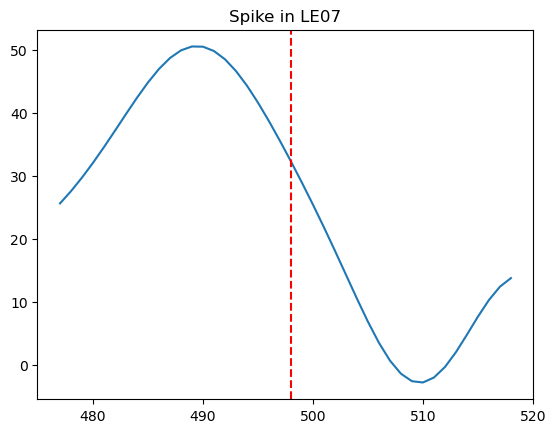

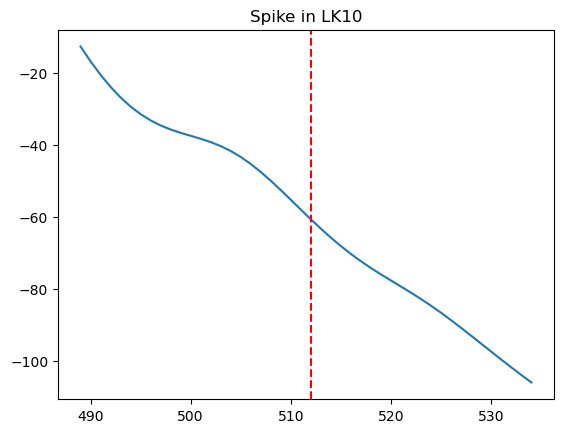

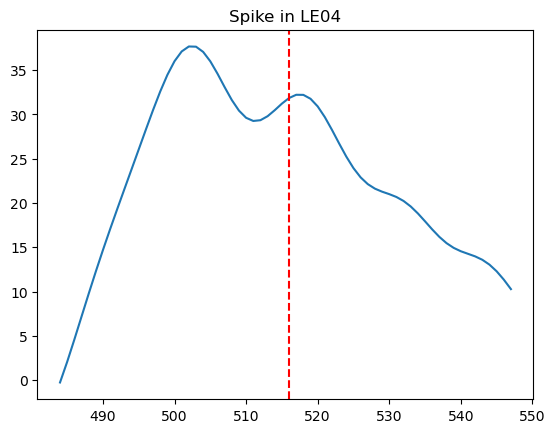

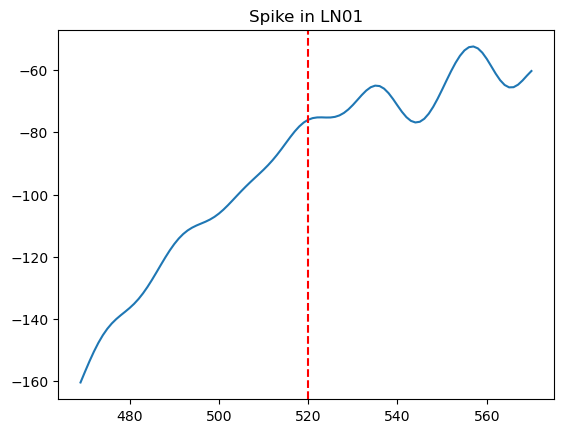

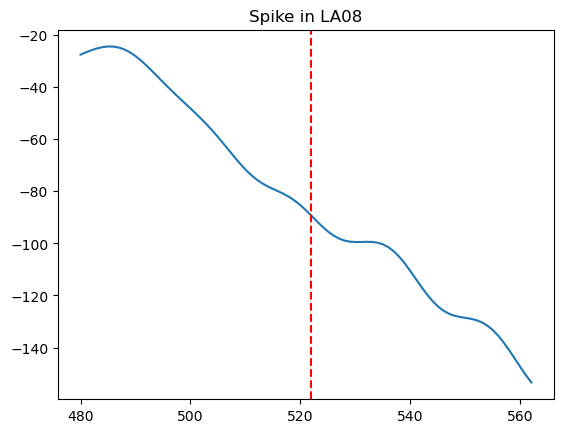

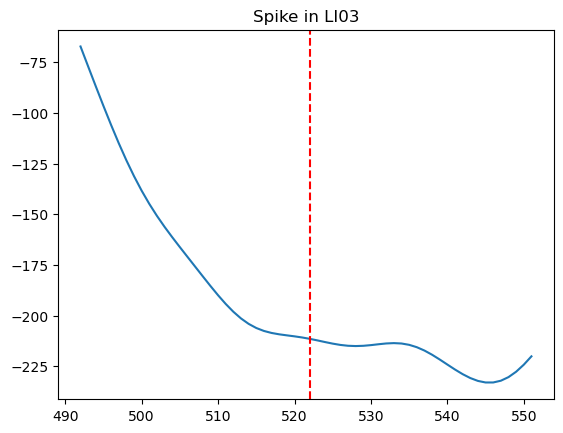

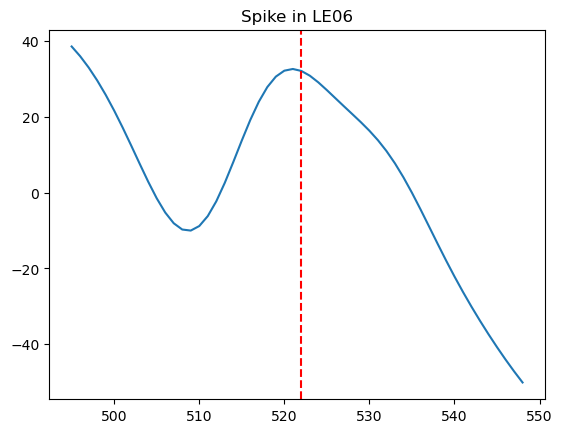

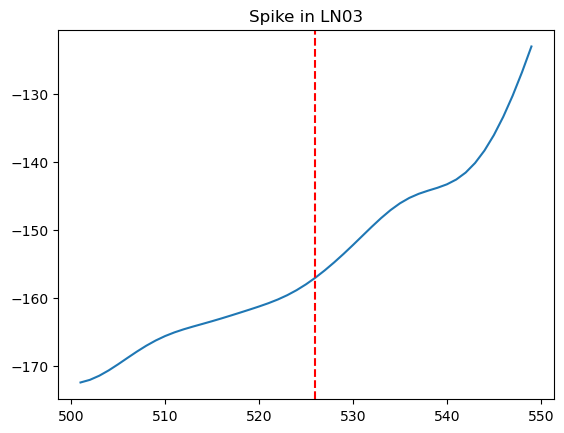

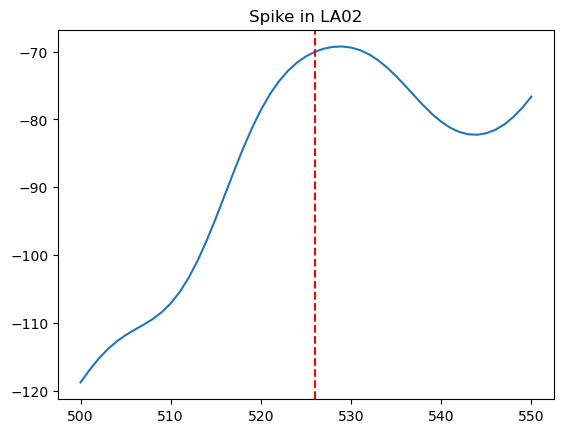

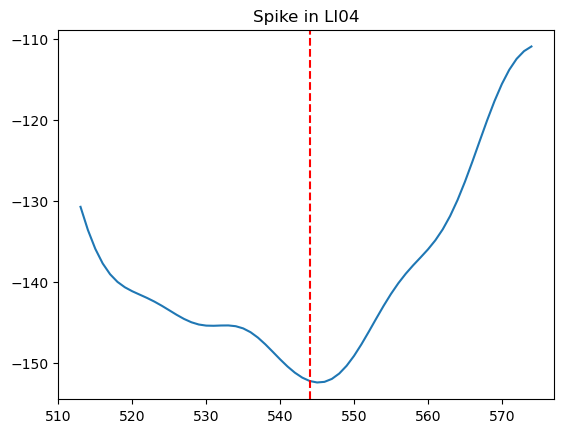

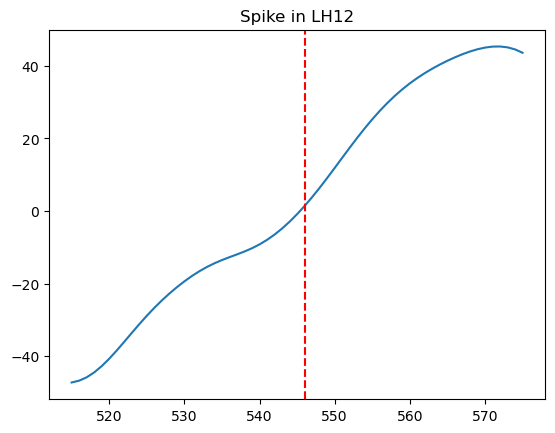

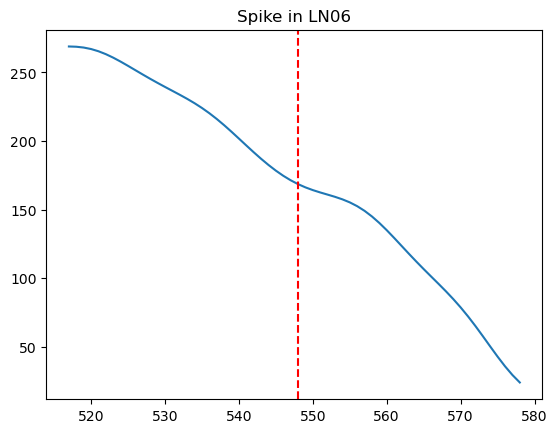

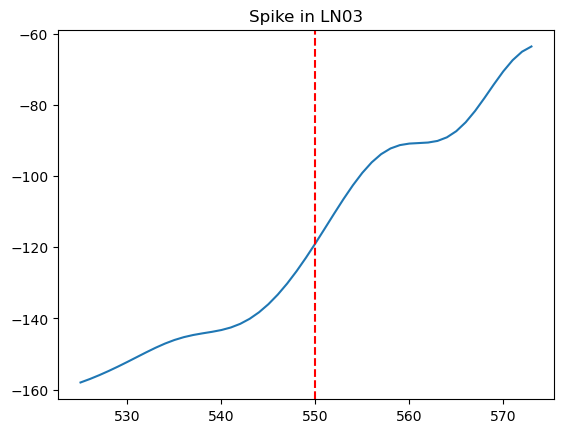

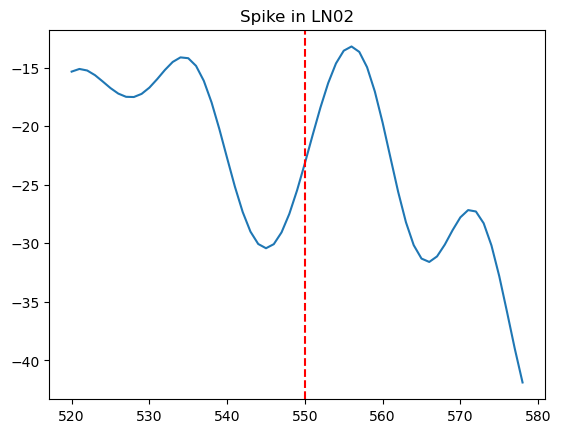

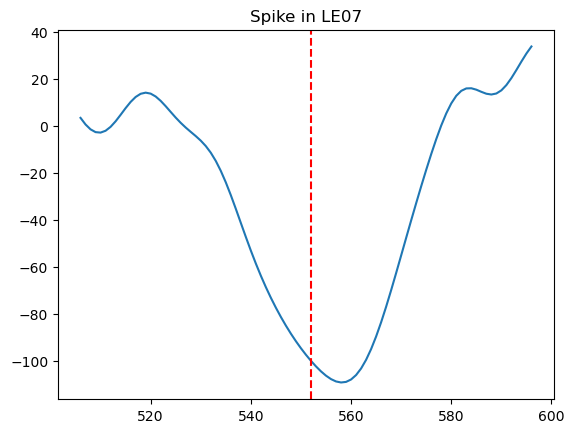

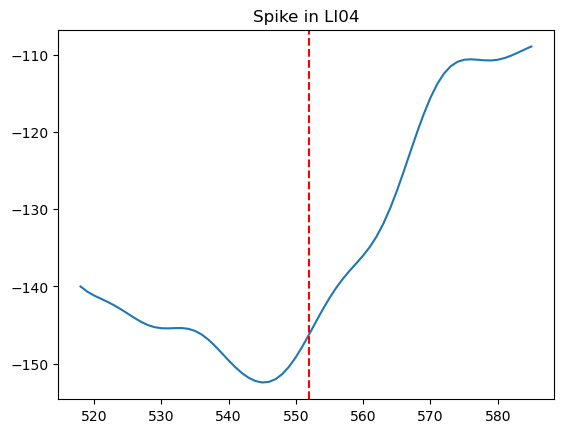

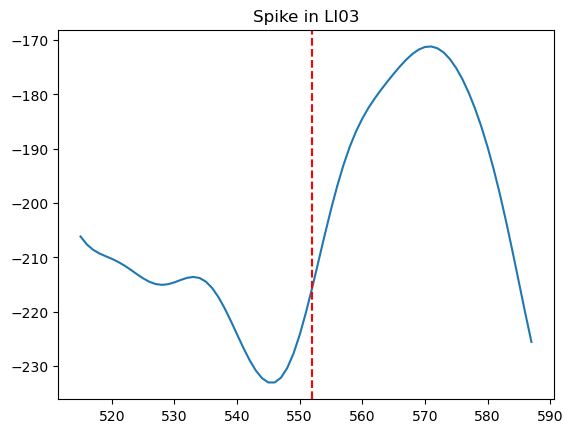

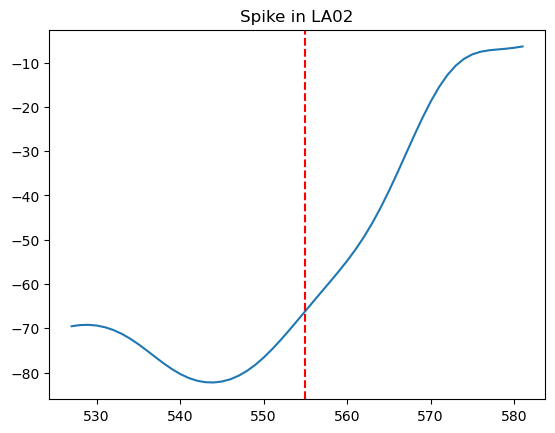

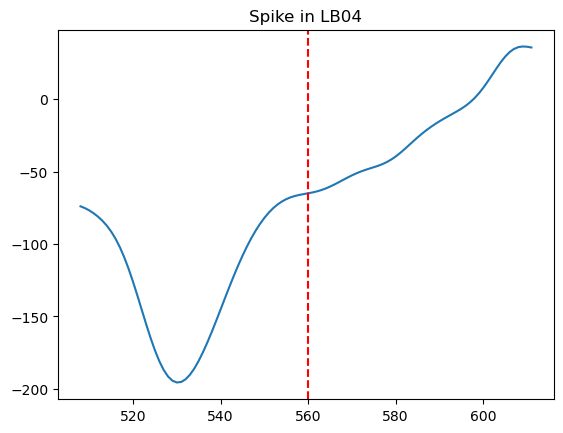

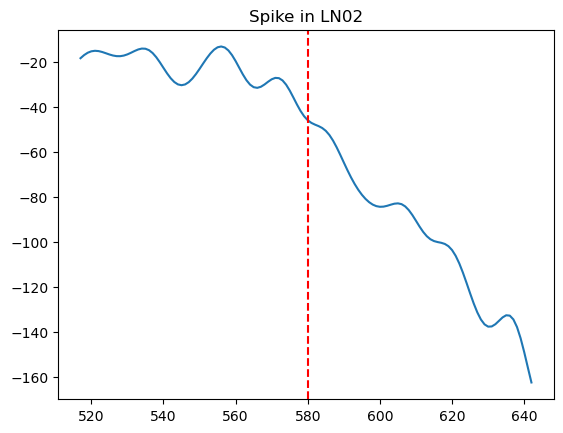

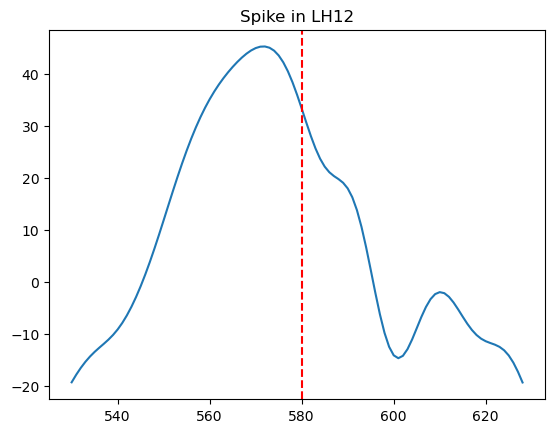

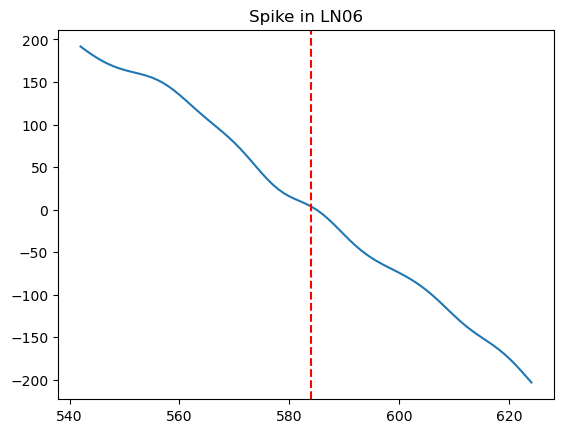

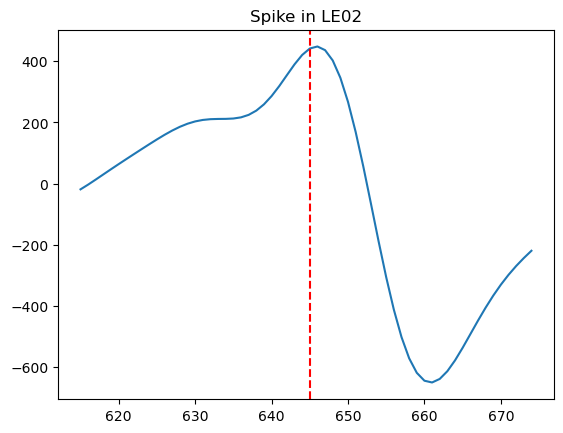

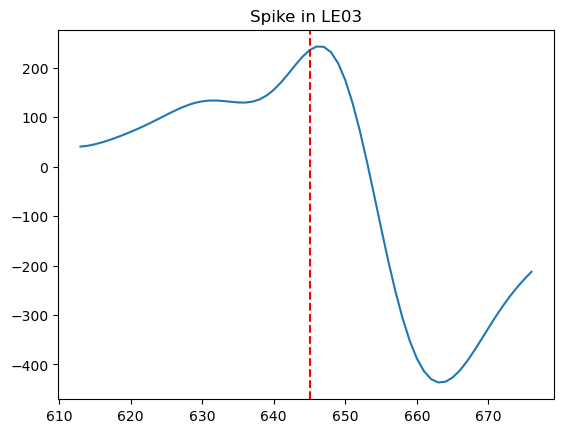

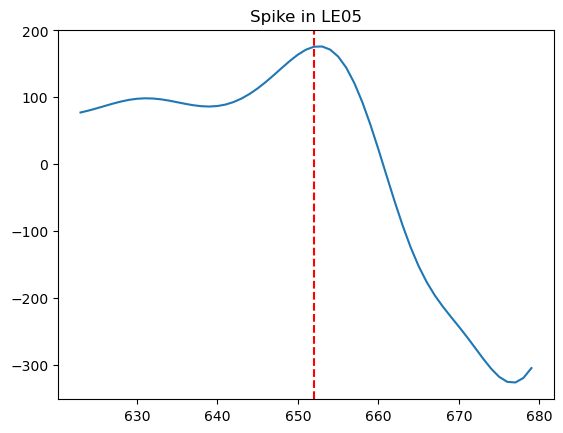

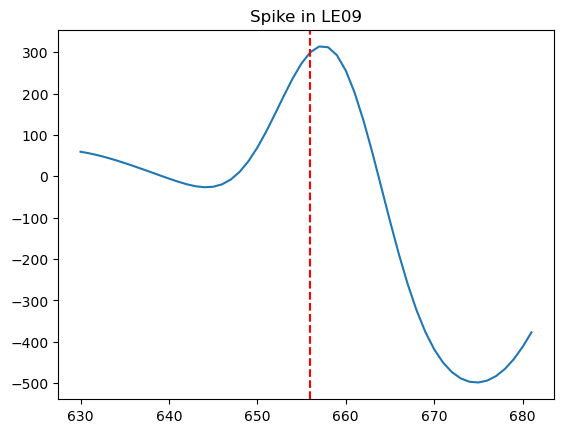

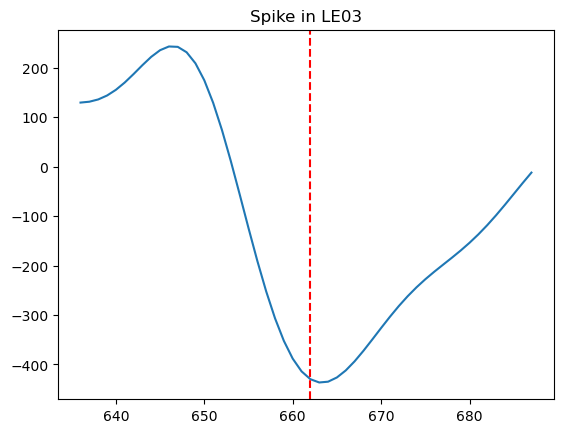

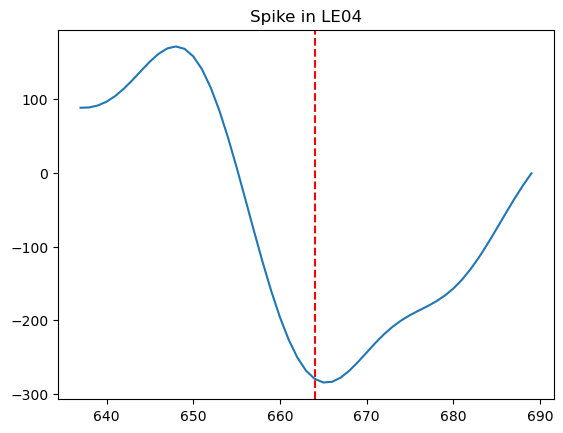

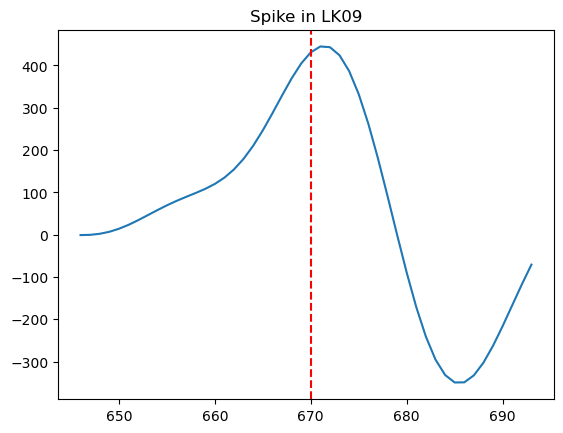

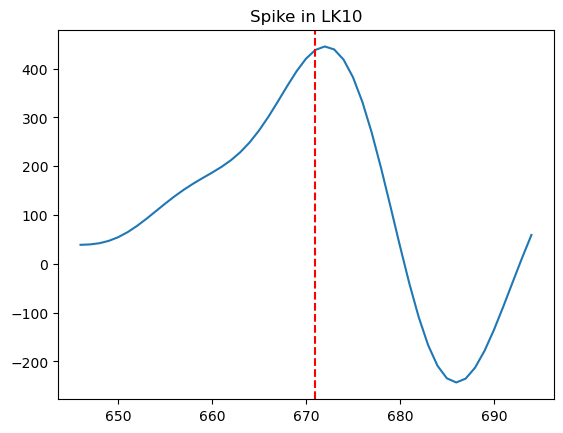

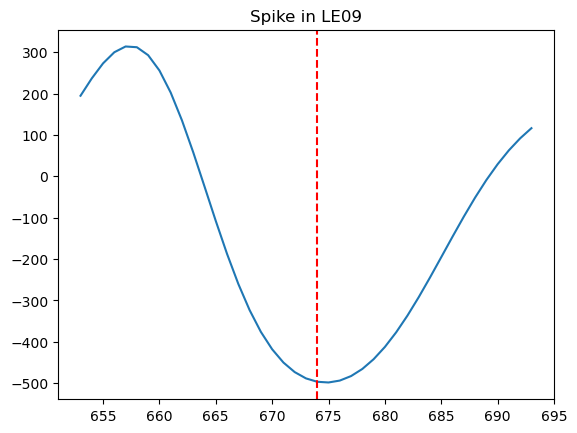

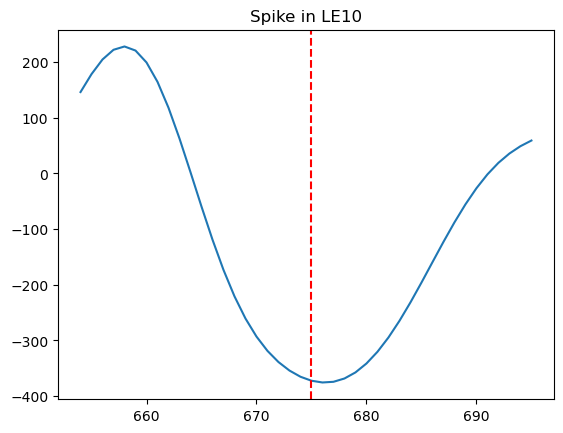

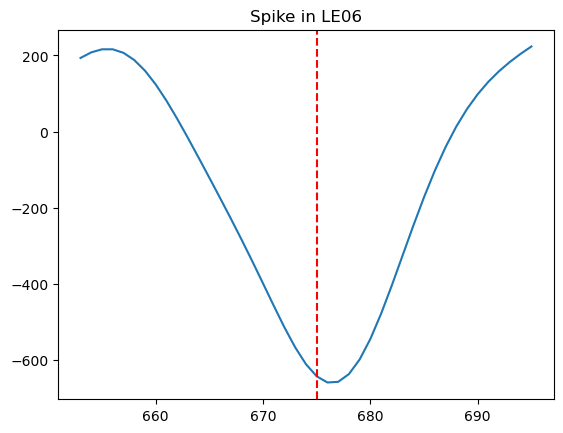

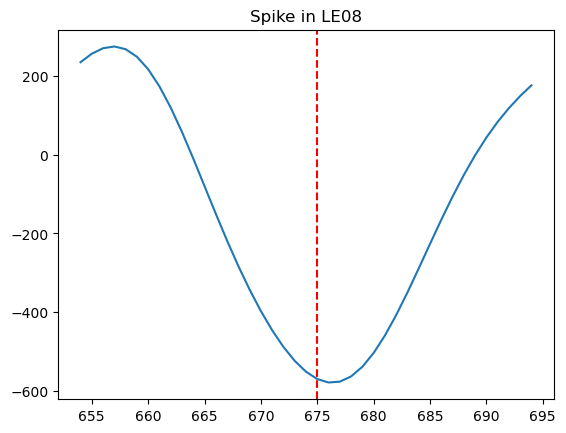

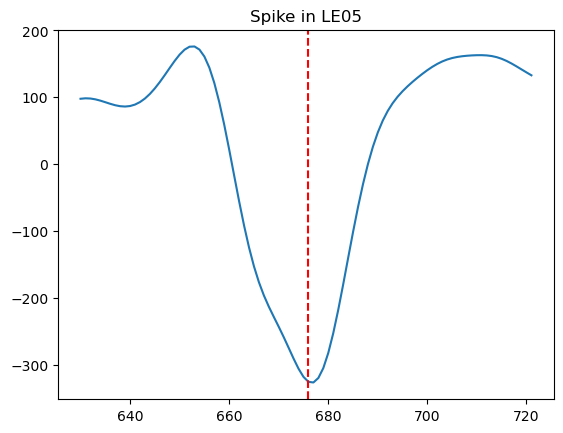

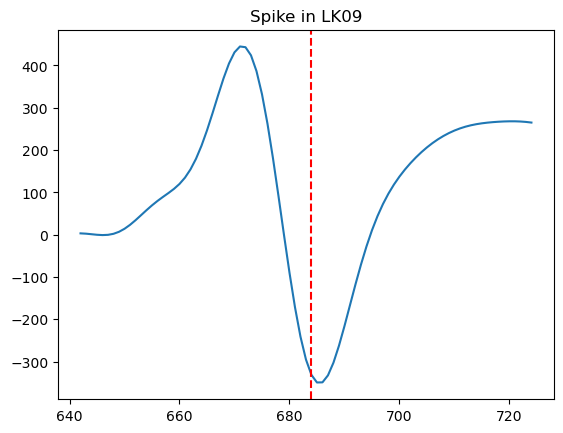

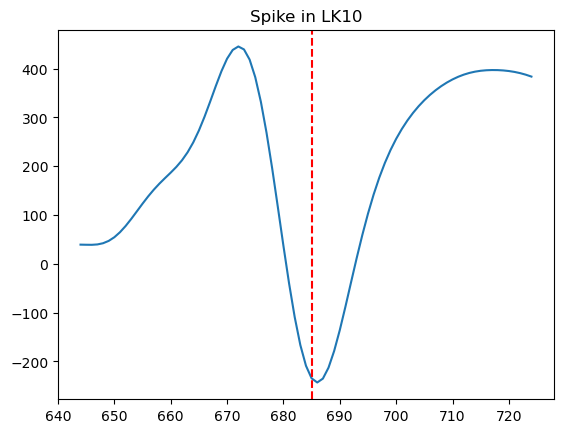

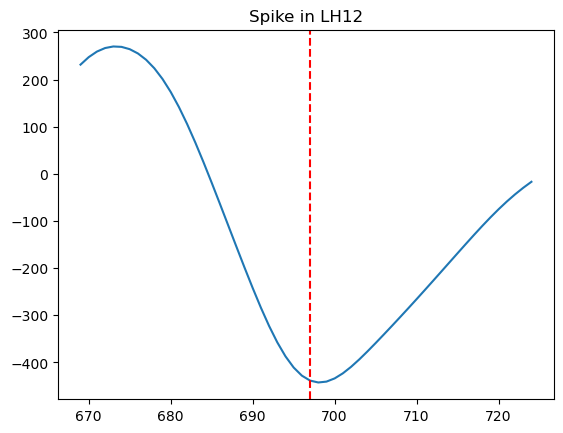

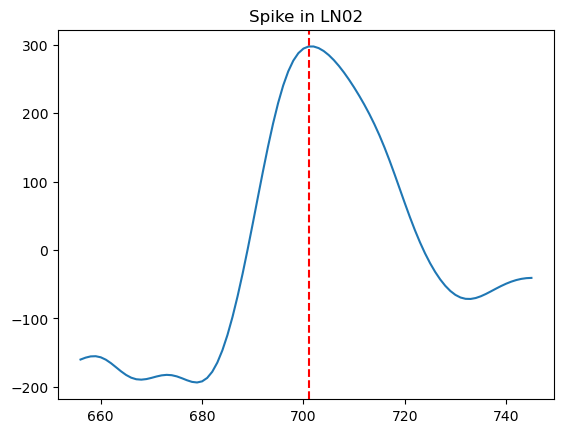

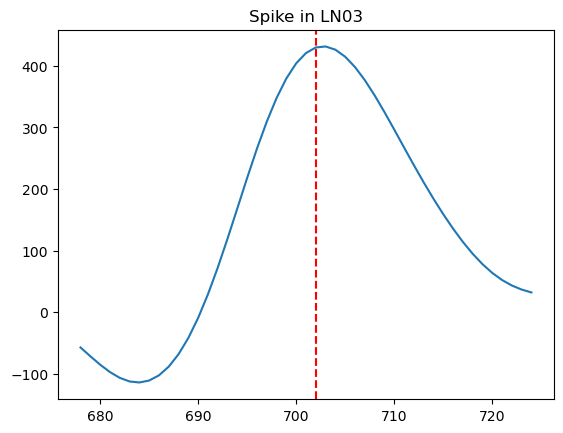

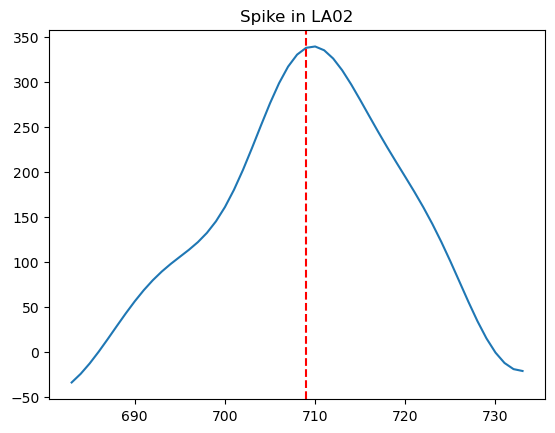

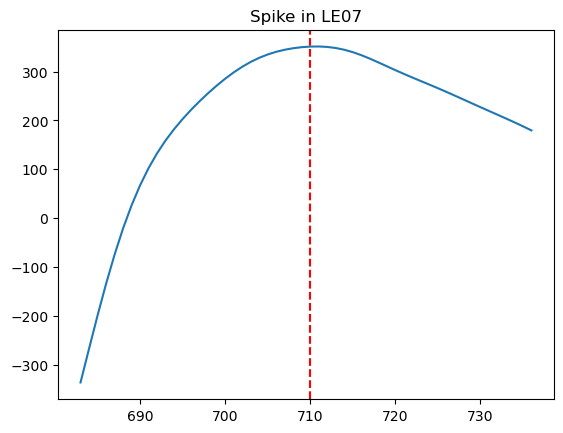

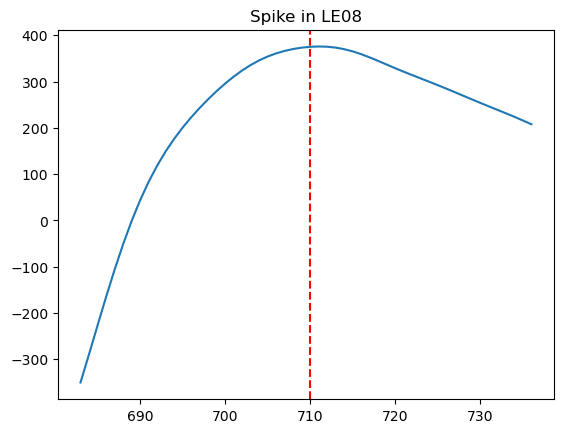

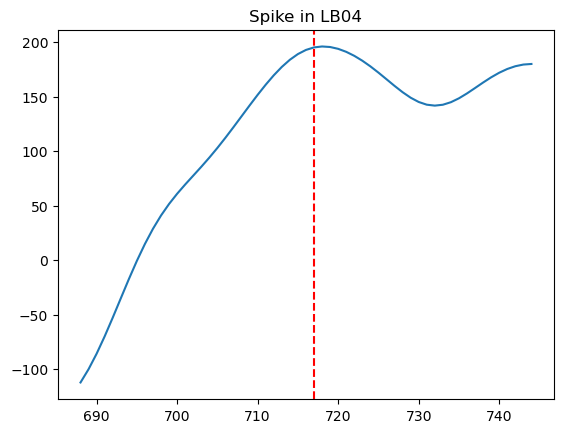

In [22]:
def plot_spike(data, spike_loc, title):
    """
    Plots the spike centered in the middle of its duration.

    :param data: Data segment containing the spike.
    :param spike_loc: Location of the spike in the data segment.
    :param duration: Duration of the spike.
    :param title: Title of the plot.
    """
    plt.plot(data)
    plt.axvline(spike_loc, color="r", linestyle="--")  # Spike location line
    plt.title(title)
    plt.show()


# Iterate through each spike in the gdf dataframe
for _, row in gdf.iterrows():
    channel_name = row["Channel Name"]
    spike_location = row["Spike Location"]
    duration = row["Spike Duration"]

    # Extract data centered around the spike from ieeg_data
    start = int(spike_location - duration / 2)
    end = int(spike_location + duration / 2)
    data_segment = ieeg_data[channel_name][start:end]

    # Plot the spike
    plot_spike(data_segment, spike_location, f"Spike in {channel_name}")

## Line Length Spike Detector

In [23]:
from lleventdetector import *
from lltransform import *

In [43]:
ieeg_data.shape

(1024, 191)

In [46]:
ieeg_data_transposed = ieeg_data.to_numpy().T
ieeg_data_transposed.shape

(191, 1024)

In [48]:
line_length_transform = lltransform(ieeg_data_transposed, fs)

In [55]:
line_length_detector_result = lleventdetector(line_length_transform, fs, 99.9, 15)

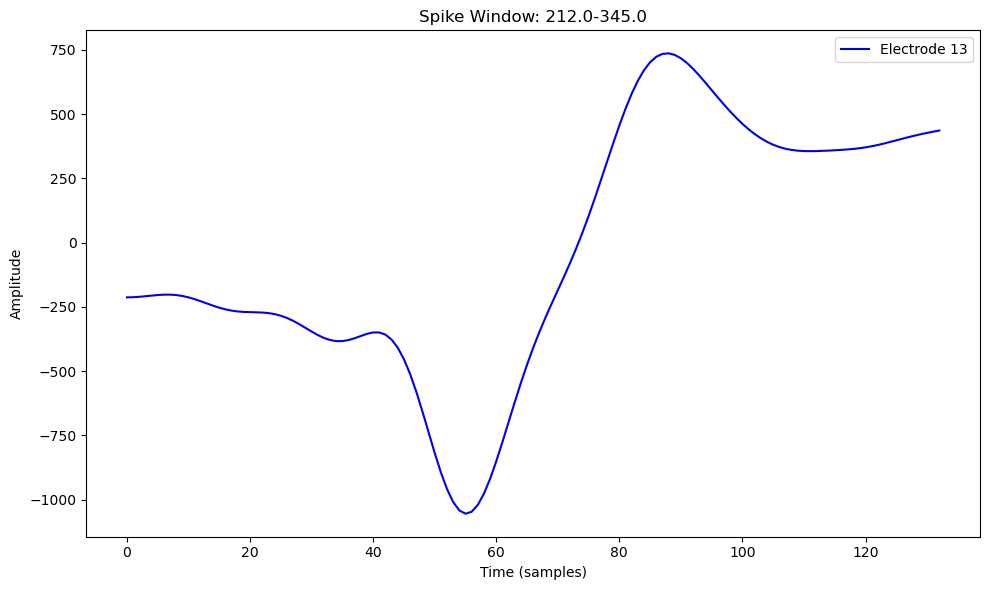

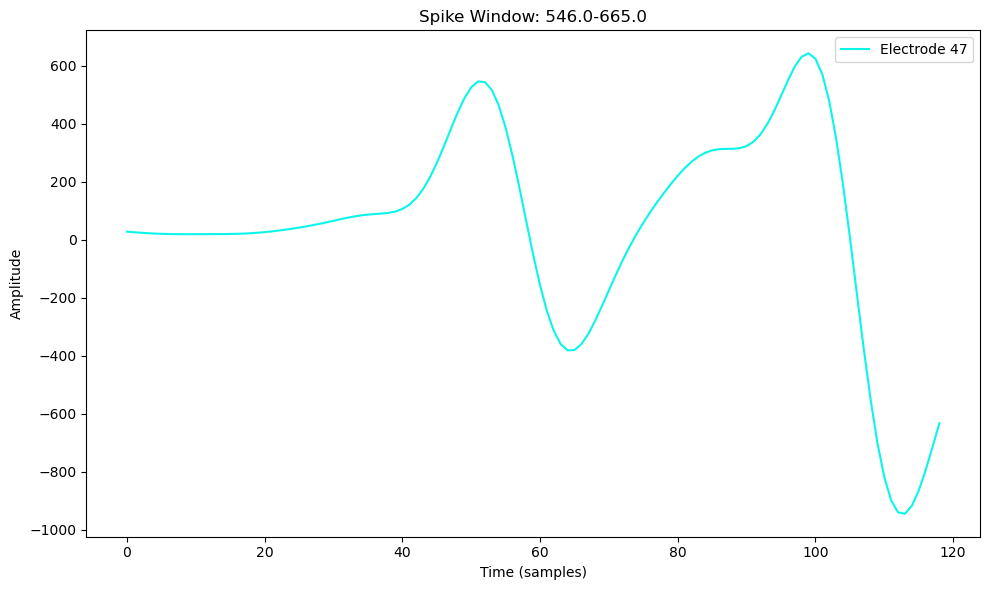

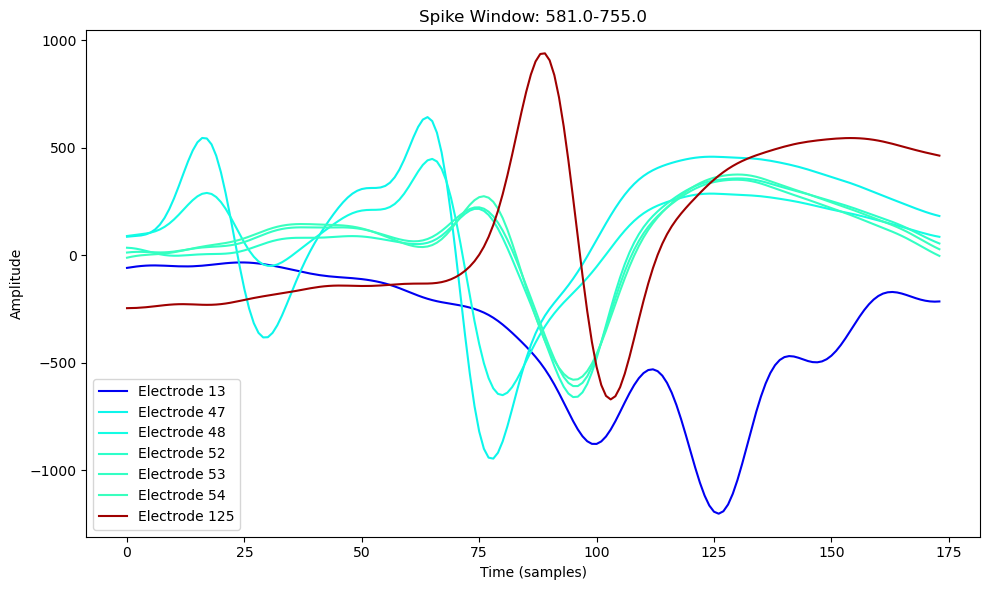

In [57]:
spike_windows, electrodes_list = line_length_detector_result

# Setup colors - if there are more electrodes than colors, they will be reused.
colors = plt.cm.jet(np.linspace(0, 1, 130))

for window, electrodes in zip(spike_windows, electrodes_list):
    start, end = window
    start -= 50  # Enlarge window by 50 at the start
    end += 50  # and 50 at the end

    plt.figure(figsize=(10, 6))

    # Get each electrode number from the comma-separated string, and plot its data.
    for elec in electrodes.split(","):
        if elec:  # Check if not an empty string
            elec_num = int(elec)
            plt.plot(
                ieeg_data_transposed[elec_num, int(start) : int(end)],
                color=colors[elec_num],
                label=f"Electrode {elec_num}",
            )

    plt.title(f"Spike Window: {start}-{end}")
    plt.legend()
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()